In [3]:
import pandas as pd
pd.set_option("max_columns", None)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
plt.style.use('seaborn')
import datetime
from matplotlib import cm
import folium

Read 311 Dataset

In [2]:
#read all 311 dataset. Since the dataset is huge, only read in the useful columns
all_311 = pd.read_csv("311_Service_Requests_from_2010_to_Present.csv", usecols = ['Created Date','Closed Date','Agency','Complaint Type','Incident Zip','Resolution Description','Community Board','Borough','Latitude','Longitude'])

/Users/qifuyin/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
all_311.head()

,Created Date,Closed Date,Agency,Complaint Type,Incident Zip,Resolution Description,Community Board,Borough,Latitude,Longitude
0,10/11/2012 12:00:00 AM,10/14/2012 12:00:00 AM,HPD,HEATING,11201,The Department of Housing Preservation and Dev...,02 BROOKLYN,BROOKLYN,40.697973,-73.996477
1,10/11/2012 12:00:00 AM,10/15/2012 12:00:00 AM,HPD,HEATING,11225,The Department of Housing Preservation and Dev...,09 BROOKLYN,BROOKLYN,40.663190,-73.945573
2,10/12/2012 12:00:00 AM,10/14/2012 12:00:00 AM,HPD,HEATING,10025,More than one complaint was received for this ...,07 MANHATTAN,MANHATTAN,40.798943,-73.960097
3,10/11/2012 12:00:00 AM,10/14/2012 12:00:00 AM,HPD,HEATING,10036,The Department of Housing Preservation and Dev...,04 MANHATTAN,MANHATTAN,40.759486,-73.989135
4,10/11/2012 12:00:00 AM,10/14/2012 12:00:00 AM,HPD,HEATING,10025,The Department of Housing Preservation and Dev...,07 MANHATTAN,MANHATTAN,40.798220,-73.963633


In [4]:
all_311.shape

(22324671, 10)

In [5]:
#use 2019 311 data for initial inspection
df_2019 = all_311.loc[all_311['Created Date'].str.contains('2019')]

Data Setup

In [6]:
def clean_data(df):
    '''clean the dataframe'''
    #Add the fix_zip function
    def fix_zip(input_zip):
        try:
            input_zip = int(float(input_zip))
        except:
            try:
                input_zip = int(input_zip.split('-')[0])
            except:
                return np.NaN
        if input_zip < 10000 or input_zip > 19999:
            return np.NaN
        return str(input_zip)
    
    #fix the zip
    df['Incident Zip'] = df['Incident Zip'].apply(fix_zip)
    
    #Convert times to datetime and create a processing time column
    df['Created Date'] = df['Created Date'].apply(lambda x:datetime.datetime.strptime(x,'%m/%d/%Y %I:%M:%S %p'))
    df = df[df['Closed Date'].apply(lambda x: isinstance(x, str))]
    df['Closed Date'] = df['Closed Date'].apply(lambda x:datetime.datetime.strptime(x,'%m/%d/%Y %I:%M:%S %p'))
    df['processing_time'] =  df['Closed Date'] - df['Created Date']
    
    #Finally, get rid of negative processing times and return the final data frame
    df = df[df['processing_time']>=datetime.timedelta(0,0,0)]
    
    #drop all rows that have any nans in them 
    df = df.dropna(how='any')
    
    #get rid of unspecified boroughs
    df = df[df['Borough'] != 'Unspecified']
    
    return df

In [7]:
df_2019_cleaned = clean_data(df_2019)

/Users/qifuyin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/qifuyin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/qifuyin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

In [8]:
df_2019_cleaned.head()

,Created Date,Closed Date,Agency,Complaint Type,Incident Zip,Resolution Description,Community Board,Borough,Latitude,Longitude,processing_time
8874199,2019-01-03 14:01:00,2019-01-04 12:00:00,DSNY,Sanitation Condition,10452,The Department of Sanitation removed the items.,04 BRONX,BRONX,40.844065,-73.920989,21:59:00
8874961,2019-01-01 01:17:45,2019-01-01 02:23:50,NYPD,Noise - Street/Sidewalk,11419,The Police Department responded to the complai...,09 QUEENS,QUEENS,40.685876,-73.832368,01:06:05
8875234,2019-01-01 00:29:00,2019-01-01 00:30:00,DOT,Traffic Signal Condition,11208,Service Request status for this request is ava...,05 BROOKLYN,BROOKLYN,40.669725,-73.860962,00:01:00
8875433,2019-01-01 00:06:00,2019-01-01 01:20:00,DOT,Traffic Signal Condition,10459,Service Request status for this request is ava...,01 BRONX,BRONX,40.819694,-73.901602,01:14:00
8875500,2019-01-01 00:37:49,2019-01-01 04:36:44,NYPD,Noise - Residential,10463,The Police Department responded to the complai...,08 BRONX,BRONX,40.883121,-73.892177,03:58:55


In [9]:
#df_2019_cleaned.to_csv('311_2019', index=False)  

In [10]:
df_2019_cleaned.shape

(2095338, 11)

# Explanatory Analysis for 2019 311 Service Request Data

Incidents by borough

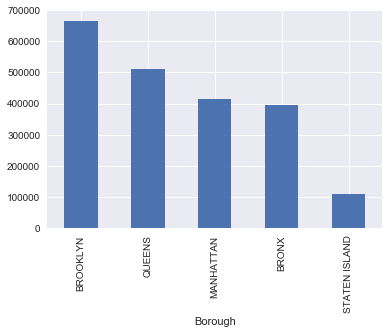

In [11]:
df_2019_cleaned.groupby('Borough').size().sort_values(ascending=False).plot(kind='bar')

Incidents by agency

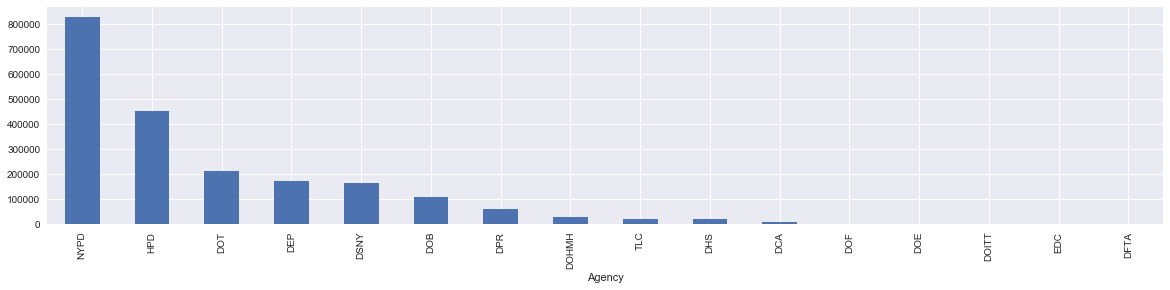

In [12]:
df_2019_cleaned.groupby('Agency').size().sort_values(ascending=False).plot(kind='bar', figsize=(20,4))

Incidents by agency and borough

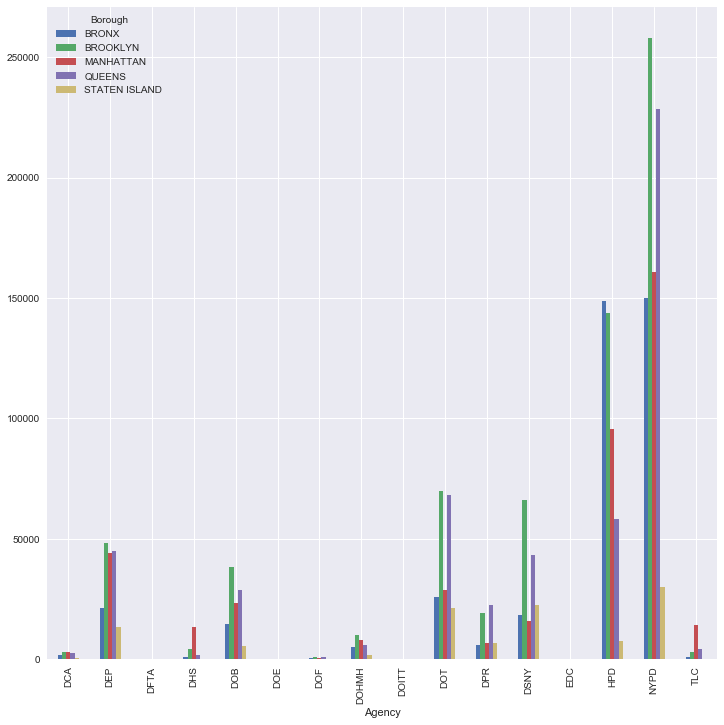

In [13]:
agency_borough = df_2019_cleaned.groupby(['Agency','Borough'])
agency_borough.size().unstack().plot(kind='bar',figsize=(12,12))

Incidents by time

In [14]:
df_2019_cleaned['yyyymm'] = df_2019_cleaned['Created Date'].apply(lambda x:datetime.datetime.strftime(x,'%Y%m'))

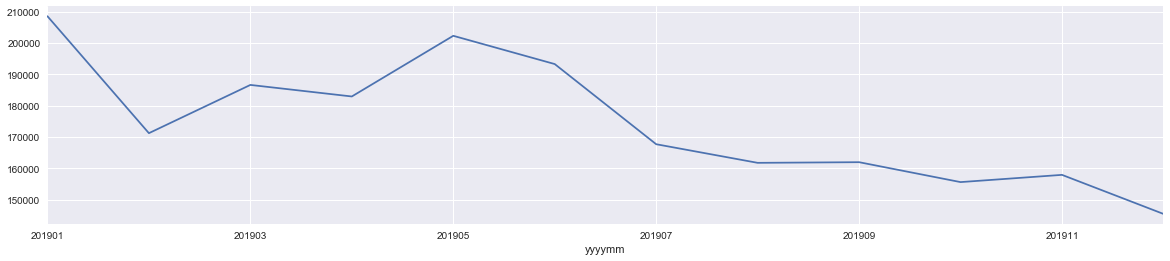

In [15]:
df_2019_cleaned.groupby('yyyymm').size().plot(kind='line', figsize=(20,4))

Incidents by time and agency

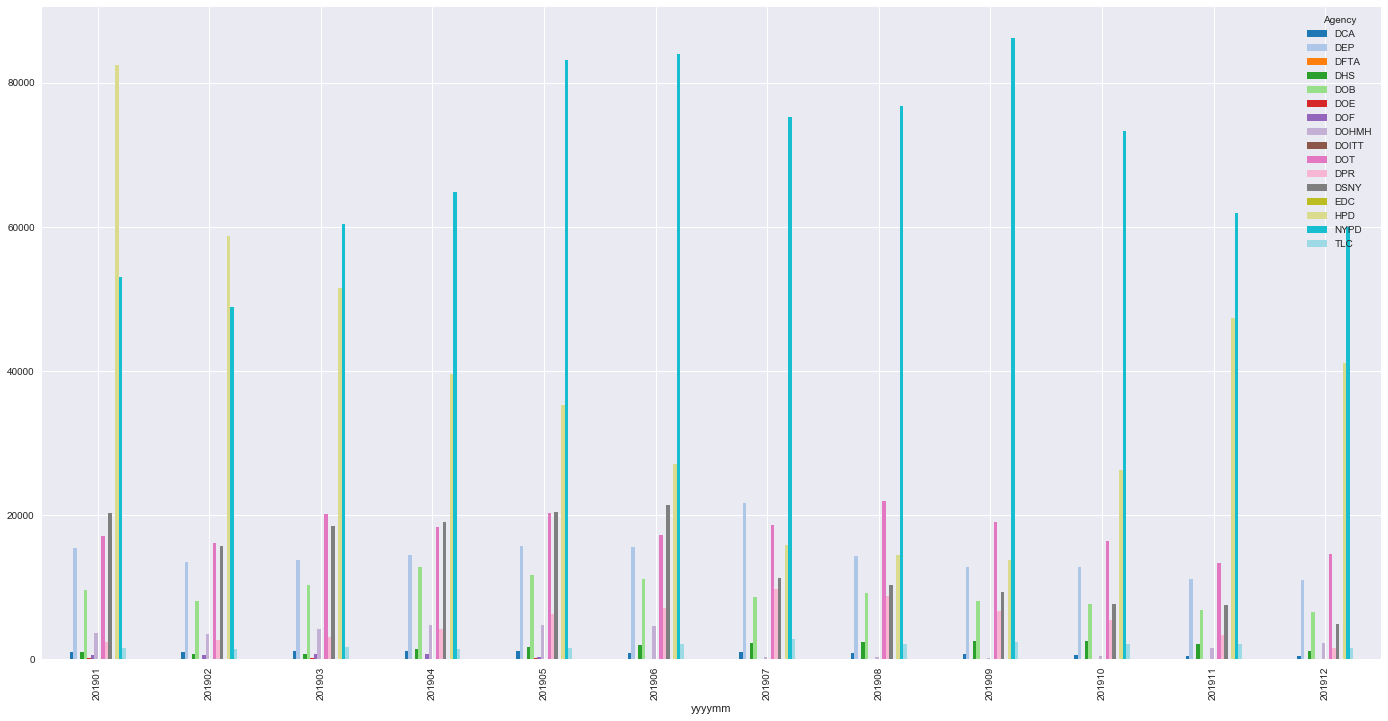

In [16]:
cmap = cm.get_cmap('tab20')
df_2019_cleaned.groupby(['yyyymm','Agency']).size().unstack().plot(kind='bar',figsize=(24,12),cmap=cmap)

Incidents by borough and agency

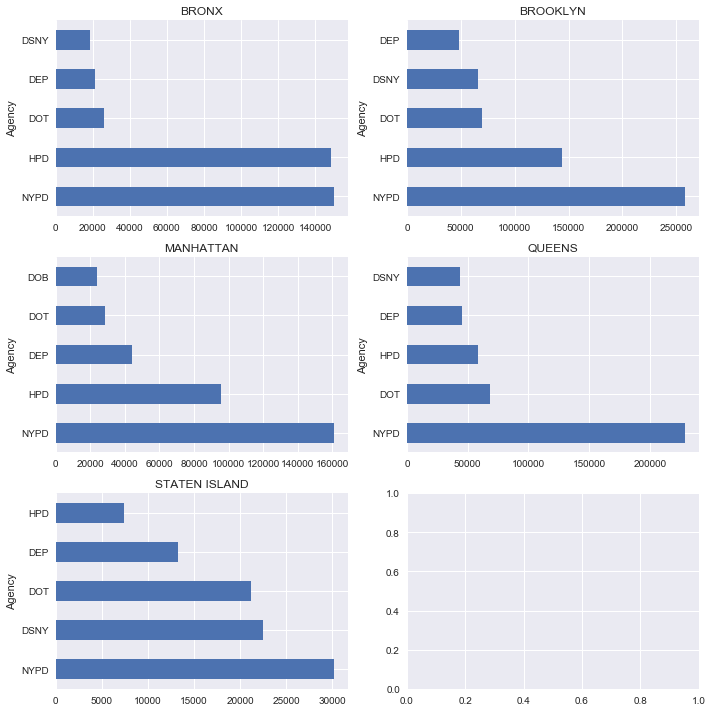

In [17]:
agency_borough = df_2019_cleaned.groupby(['Agency','Borough']).size().unstack()

COL_NUM = 2
ROW_NUM = 3
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(10,10))
#plot for top 5 agency for each borough
for i, (borough, agency_count) in enumerate(agency_borough.items()): 
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    agency_count = agency_count.sort_values(ascending=False)[:5] 
    agency_count.plot(kind='barh', ax=ax)
    ax.set_title(borough)
plt.tight_layout() 

Calculate the processing time

In [18]:
#convert to float version of 1 day
df_2019_cleaned['float_time'] =df_2019_cleaned['processing_time'].apply(lambda x:x/np.timedelta64(1, 'D'))

In [19]:
df_2019_cleaned.tail()

,Created Date,Closed Date,Agency,Complaint Type,Incident Zip,Resolution Description,Community Board,Borough,Latitude,Longitude,processing_time,yyyymm,float_time
18644047,2019-03-06 14:30:53,2019-03-07 20:28:00,DOT,Street Condition,11234,The Department of Transportation inspected thi...,18 BROOKLYN,BROOKLYN,40.606248,-73.905013,1 days 05:57:07,201903,1.247998
18848235,2019-01-31 16:25:47,2019-02-03 14:45:35,HPD,HEAT/HOT WATER,10039,The Department of Housing Preservation and Dev...,10 MANHATTAN,MANHATTAN,40.821971,-73.939839,2 days 22:19:48,201901,2.930417
18853620,2019-01-31 17:32:26,2019-02-03 14:45:35,HPD,HEAT/HOT WATER,10039,The Department of Housing Preservation and Dev...,10 MANHATTAN,MANHATTAN,40.821971,-73.939839,2 days 21:13:09,201901,2.884132
18984009,2019-02-07 10:46:54,2019-10-30 21:14:33,HPD,GENERAL,10026,The Department of Housing Preservation and Dev...,10 MANHATTAN,MANHATTAN,40.800281,-73.955419,265 days 10:27:39,201902,265.435868
19013258,2019-03-05 12:47:00,2019-03-05 12:47:00,DSNY,Derelict Vehicles,11434,The Department of Sanitation removed the items.,13 QUEENS,QUEENS,40.662919,-73.773403,0 days 00:00:00,201903,0.000000


Processing time by borough

In [20]:
df_2019_cleaned[['float_time','Borough']].groupby('Borough').describe()

float_time                                                \
                   count      mean        std  min       25%       50%   
Borough                                                                  
BRONX           394650.0  7.994763  20.858575  0.0  0.176748  1.089392   
BROOKLYN        665939.0  9.444540  27.056545  0.0  0.105556  0.648796   
MANHATTAN       415087.0  9.031021  24.581492  0.0  0.083843  0.533368   
QUEENS          510328.0  7.624489  23.283604  0.0  0.089314  0.383519   
STATEN ISLAND   109334.0  7.373282  21.602070  0.0  0.115341  0.994444   

                                     
                    75%         max  
Borough                              
BRONX          5.105321  376.841771  
BROOKLYN       4.868056  392.542512  
MANHATTAN      4.163339  386.995660  
QUEENS         3.655417  389.876644  
STATEN ISLAND  4.083519  358.944491

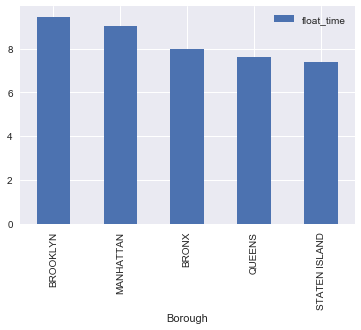

In [21]:
df_2019_cleaned[['float_time','Borough']].groupby('Borough').mean().sort_values(by='float_time',ascending = False).plot(kind='bar')

Processing time by agency. We can see DOHMH(New York City Department of Health and Mental Hygiene) has the second highest processing time among NYC agency and it is critical to New York Residents life. So, I decide to investigate further on this agency. 

In [22]:
df_2019_cleaned[['float_time','Agency']].groupby('Agency').describe()

float_time                                                        \
            count       mean        std       min        25%        50%   
Agency                                                                    
DCA       10762.0   5.642888   6.469324  0.007488   1.022057   1.963877   
DEP      172228.0   3.701657  12.439404  0.000000   0.091667   0.825694   
DFTA         92.0   9.332634   8.412381  0.059410   4.924306   8.010909   
DHS       20775.0   6.187326  24.727094  0.000394   0.021736   0.055810   
DOB      110760.0  25.512444  41.451014  0.000000   0.519488   6.593501   
DOE        1214.0  23.924964  35.099564  0.000417   1.542983   6.784346   
DOF        3063.0  19.654775  16.575017  0.002269   6.294485  14.918935   
DOHMH     30663.0  40.703699  52.334534  0.000000   1.587899   9.761910   
DOITT       373.0  19.695344  18.500623  0.583194  12.753715  15.841331   
DOT      213402.0  14.218934  32.306006  0.000000   0.600694   2.801997   
DPR       61460.0  32.463177  46.814270  0.000231   1.881956   9.008704   
DSNY     166232.0  13.163191  36.053843  0.000000   0.634722   1.761111   
EDC         226.0  20.687149  12.179412  1.852407  10.483889  18.852784   
HPD      453603.0   9.588319  14.761326  0.000000   1.897963   3.960463   
NYPD     827566.0   0.324433   1.927980  0.000197   0.055428   0.124502   
TLC       22919.0  45.908575  44.048071  0.000012   0.899149  46.395856   

                               
              75%         max  
Agency                         
DCA     15.245017   60.961424  
DEP      3.037500  352.304861  
DFTA    12.146059   60.106019  
DHS      0.130197  386.995660  
DOB     37.024742  392.542512  
DOE     31.521863  235.114190  
DOF     30.095938   92.940313  
DOHMH   74.463721  376.841771  
DOITT   21.779132  185.057558  
DOT     11.971348  380.275694  
DPR     48.147870  383.611215  
DSNY     4.088889  359.480498  
EDC     31.183200   49.080139  
HPD     12.614456  362.736111  
NYPD     0.251725  118.729016  
TLC     76.152818  335.559120

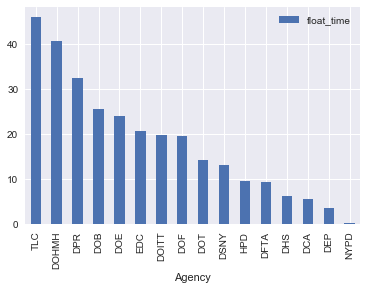

In [23]:
df_2019_cleaned[['float_time','Agency']].groupby('Agency').mean().sort_values(by='float_time',ascending = False).plot(kind='bar')

# Investigation on DOHMH 2019 311 Service Request Data

In [24]:
df_DOHMH = df_2019_cleaned[df_2019_cleaned['Agency'] == 'DOHMH']

In [25]:
df_DOHMH[['float_time','Borough']].groupby('Borough').describe()

float_time                                                  \
                   count       mean        std  min       25%        50%   
Borough                                                                    
BRONX             5068.0  38.713590  57.783518  0.0  0.905830   5.000000   
BROOKLYN         10226.0  43.295050  53.287505  0.0  2.000012  11.000000   
MANHATTAN         7825.0  37.721007  48.565509  0.0  1.000000   8.000012   
QUEENS            5806.0  40.459522  51.723415  0.0  2.653174  11.000000   
STATEN ISLAND     1738.0  45.504606  47.046891  0.0  5.193244  21.039722   

                                      
                     75%         max  
Borough                               
BRONX          73.752370  376.841771  
BROOKLYN       82.248655  373.230521  
MANHATTAN      60.931562  374.209363  
QUEENS         70.018892  376.662859  
STATEN ISLAND  82.446751  303.001678

Incidents by compliant type. "Rodent" complaints have taken the more than half of the service requests, it is worthy a deeper look of how DOHMH performs on this compliant.

In [26]:
df_DOHMH.groupby('Complaint Type').size().groupby(level=0).apply(lambda x: x / len(df_DOHMH)).sort_values(ascending=False)

Complaint Type
Rodent                            0.585233
Indoor Air Quality                0.090924
Food Establishment                0.088348
Food Poisoning                    0.058181
Unsanitary Animal Pvt Property    0.036820
Standing Water                    0.034308
Indoor Sewage                     0.026025
Day Care                          0.016698
Mosquitoes                        0.013893
Asbestos                          0.012262
Unsanitary Pigeon Condition       0.010697
Mold                              0.007599
Beach/Pool/Sauna Complaint        0.006686
Drinking Water                    0.005381
Poison Ivy                        0.002022
Non-Residential Heat              0.001174
Harboring Bees/Wasps              0.001174
Cooling Tower                     0.000685
Lifeguard                         0.000620
Radioactive Material              0.000359
X-Ray Machine/Equipment           0.000294
Construction Lead Dust            0.000261
Bottled Water                     0.000

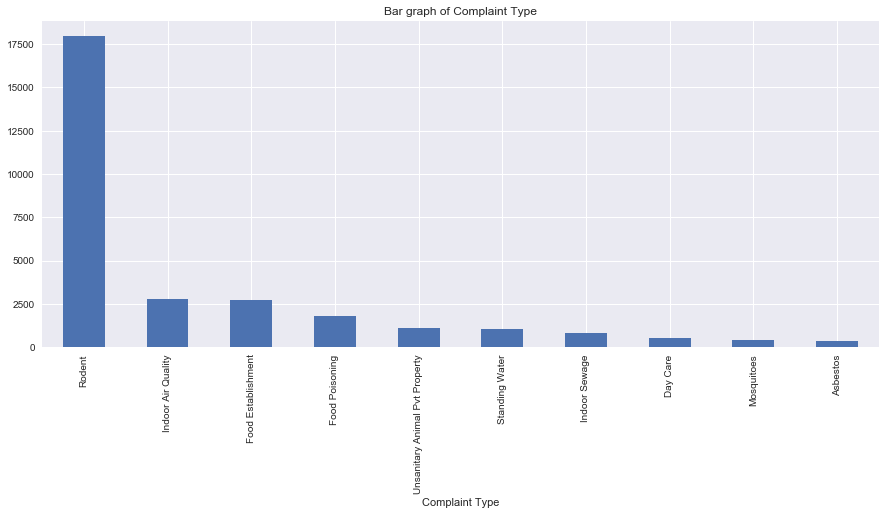

In [63]:
df_DOHMH.groupby('Complaint Type').size().sort_values(ascending=False)[:10].plot(kind='bar', figsize=(15,6),
                                                                          title='Bar graph of Complaint Type');

In [28]:
df_DOHMH[['float_time','Complaint Type']].groupby('Complaint Type').describe()

float_time                                    \
                                    count        mean        std        min   
Complaint Type                                                                
Asbestos                            376.0   19.255423  32.250821   0.007431   
Beach/Pool/Sauna Complaint          205.0   15.159940  17.049539   0.086655   
Bottled Water                         8.0   68.465503  34.034817  32.015370   
Construction Lead Dust                8.0    7.401293   4.399914   2.061389   
Cooling Tower                        21.0   39.183805  36.252331   1.860405   
Day Care                            512.0  211.640325  98.698521  14.149375   
Drinking Water                      165.0   54.581669  35.466609   0.050891   
Food Establishment                 2709.0   56.948805  13.871467   0.030532   
Food Poisoning                     1784.0   16.967839  31.671102   0.000000   
Harboring Bees/Wasps                 36.0   16.609553   5.885371   9.826632   
Indoor Air Quality                 2788.0   19.088213  34.987738   0.002639   
Indoor Sewage                       798.0   16.980569  32.182576   0.010266   
Lifeguard                            19.0   11.548266  10.741162   0.778380   
Mold                                233.0   14.763622  30.440613   0.007801   
Mosquitoes                          426.0  113.811749  43.148821  13.782280   
Non-Residential Heat                 36.0    2.992201   2.383097   0.045150   
Poison Ivy                           62.0   29.913208  20.124458   1.085498   
Radioactive Material                 11.0   83.267940  63.240146   2.124479   
Rodent                            17945.0   41.519564  50.021666   0.000000   
Standing Water                     1052.0    8.952756   6.731246   0.000000   
Tanning                               3.0    8.873858   9.504401   0.935891   
Unsanitary Animal Pvt Property     1129.0   40.112935  48.090802   0.000000   
Unsanitary Pigeon Condition         328.0   34.680067  43.198018   0.000000   
X-Ray Machine/Equipment               9.0   93.919003  98.412321   5.662986   

                                                                                
                                       25%         50%         75%         max  
Complaint Type                                                                  
Asbestos                          1.646551    5.837274   13.132815  140.059525  
Beach/Pool/Sauna Complaint        3.244653   13.049039   18.115185  135.985810  
Bottled Water                    33.673096   67.218293   97.719679  116.040532  
Construction Lead Dust            4.149531    6.433009   11.968576   12.933148  
Cooling Tower                    13.868542   30.887569   55.857894  112.957465  
Day Care                        130.795515  222.767645  293.867277  376.841771  
Drinking Water                   28.647118   47.922153   72.844884  160.839491  
Food Establishment               60.412199   60.596632   60.745961   61.022870  
Food Poisoning                    0.582587    1.708333   11.006968  140.902789  
Harboring Bees/Wasps             12.820799   15.333466   19.115747   42.182905  
Indoor Air Quality                0.674980    1.830995    7.204902  254.938681  
Indoor Sewage                     0.788866    2.015341    6.263481  120.239433  
Lifeguard                         2.047211   12.017720   15.650046   45.025914  
Mold                              0.636227    1.192025    3.053044  111.708634  
Mosquitoes                       81.961869  111.023235  140.808707  232.618275  
Non-Residential Heat              1.001372    1.981591    5.761293    6.684595  
Poison Ivy                       11.878139   21.963015   52.652729   59.817326  
Radioactive Material             32.270069   42.164549  145.743669  154.037500  
Rodent                            1.791759    9.000000   89.646238  175.458877  
Standing Water                    5.000000    8.000000   12.000000   48.000000  
Tanning                           

"Rodent" incidents by time. The complaints peak at spring season, but the processing time increases disproportionally. This might indicate the inefficiency of DOHMH handling the huge incoming complaints.It is also strange for summer season to have only few cases. Maybe it is the data entry error, so it is worthy of taking a look of previous years' data

In [29]:
df_DOHMH[df_DOHMH['Complaint Type'] == 'Rodent'][['float_time','yyyymm']].groupby('yyyymm').describe()

float_time                                                             \
            count        mean        std         min         25%         50%   
yyyymm                                                                         
201901     1998.0    6.277139   7.547579    0.000000    1.000000    4.671869   
201902     1862.0    5.306095   7.249994    0.000000    0.000000    3.000000   
201903     2389.0    4.720261   6.262247    0.000000    0.000000    3.000000   
201904     2766.0   15.482170  34.738244    0.000000    0.000000    3.000000   
201905     3235.0  115.807194  27.317695    0.000000  100.646684  114.513241   
201906     3108.0   87.659187  18.841159   61.613044   71.735735   83.283027   
201907        1.0  138.118437        NaN  138.118437  138.118437  138.118437   
201908        3.0  100.973588   8.574505   91.079826   98.336400  105.592975   
201909       24.0   72.344057  14.069875   43.658229   65.697222   72.077581   
201910      169.0   26.510755  16.111680    3.772049   14.989329   22.827118   
201911      989.0    8.432228   8.661368    0.000000    1.328044    6.538067   
201912     1401.0    4.616989   5.585618    0.000000    0.000000    2.848565   

                                
               75%         max  
yyyymm                          
201901    9.000000  108.626123  
201902    8.000000   78.000000  
201903    7.000000   63.298958  
201904    9.000000  172.234850  
201905  136.219624  175.458877  
201906  104.803255  124.620845  
201907  138.118437  138.118437  
201908  105.920469  106.247963  
201909   79.175582  104.822604  
201910   35.279896   88.024248  
201911   12.232188   53.887789  
201912    7.199398   32.382211

Further investigation of exact action taken

In [30]:
df_DOHMH['Resolution Description'].value_counts(sort=True)

The Department of Health and Mental Hygiene will review your complaint to determine appropriate action.  Complaints of this type usually result in an inspection.  Please call 311 in 30 days from the date of your complaint for status                                                                                                                                                                                                                                                                            8868
The Department of Health and Mental Hygiene will review your Service Request to determine appropriat                                                                                                                                                                                                                                                                                                                                                                                                           

In [31]:
under_review_wait = ['The Department of Health and Mental Hygiene will review your complaint to determine appropriate action.  Complaints of this type usually result in an inspection.  Please call 311 in 30 days from the date of your complaint for status',
                    'The Department of Health and Mental Hygiene will review your Service Request to determine appropriat',
                    'The Department of Health and Mental Hygiene will review your complaint to determine appropriate action.  Complaints of this type usually result in an inspection.  Please call 311 in 30 days from the date of your complaint for status.  Please note your Service Request number for future reference.',
                    'The Department of Health and Mental Hygiene will review your Service Request to determine appropriat',
                    'The Department of Health and Mental Hygiene will review your complaint to determine appropriate action.  Complaints of this type usually result in complainant contact or an inspection. You may be contacted if you provided a phone number.  Status will be available 45 days after the date of your complaint by calling 311. If you are experiencing medical symptoms, please seek medical attention or consult the NYC Poison Control Center. Please note your Service Request number for future reference.',
                    'The Department of Health and Mental Hygiene will review your complaint within 24 hours.  Complaints of this type usually result in complainant contact and/or inspection by the agency. Initial status will be available 14 days after the date of your complaint by calling 311. If you are experiencing medical symptoms, please seek medical attention or consult the NYC Poison Control Center which can be reached through 311.   Please note your Service Request number for future reference.',
                    'The Department of Health and Mental Hygiene will review this Service Request. These types of complaints usually result in agency contact or an inspection. Status will be available at www.nyc.gov/311 within 30 days of the date you submitted the request. Note the Service Request number for future reference.',
                    'The Department of Health and Mental Hygiene will review your complaint to determine appropriate action.  Complaints of this type usually result in agency contact or an inspection. Status will be available 30 days after the date of your complaint by calling 311 or going online to www.nyc.gov/311. Note your Service Request number for future reference.',
                    'The Department of Health and Mental Hygiene will review your complaint to determine appropriate acti',
                    'The Department of Health and Mental Hygiene will review the Service Request. Complaints of this type usually result in Agency contact or an inspection. Status will be available from 311 within 45 days of the Service Request submission date.  Please note the Service Request number for future reference.',
                    'The Department of Health and Mental Hygiene will review your complaint to determine appropriate action.  Complaints of this type usually result in complainant contact or an inspection by the agency. The Department may contact you if you provided a phone number.  Status will be available 45 days after the date of your complaint by calling 311.  Please note your service request number for future reference.',
                    'Callers should contact the DOHMH Foodborne Illness unit directly at (646) 632-6103 weekdays from 9AM to 5PM.  DOHMH will review your complaint within 24 hours.  Complaints of this type usually result in complainant contact and/or inspection. Initial status will be available 14 days after the date of your complaint. If you are experiencing medical symptoms, please seek medical attention or consult the NYC Poison Control Center.  Please note your Service Request number for future reference.']

violations_found = ['The Department of Health and Mental Hygiene found violations on the property you reported. Follow-up inspections will be scheduled.',
                   'The Department of Health and Mental Hygiene inspected the property you reported and issued notices for minor violations.',
                   'The Department of Health and Mental Hygiene has determined that the reported incident is isolated.  The establishment will be inspected according to its normal schedule for sanitary inspections.']

duplicate_complaint = ['This service request was closed because the Department of Health and Mental Hygiene received an earlier complaint about the same location.  You can find inspection results for this address by going to the online Rat Portal at www.nyc.gov/rats.']

no_violation = ['The Department of Health and Mental Hygiene inspected the property you reported and did not find any violations at the time of the inspection. The property passed inspection.']

no_access = ['The Department of Health and Mental Hygiene tried to inspect the property you reported but could not access the site. If you have information that will help the inspector access the site, please go online to nyc.gov/311 or call 311 and refile your complaint with contact information.',
            'The Department of Health and Mental Hygiene could not conduct an inspection at the property you reported because dangerous conditions at that site make it unsafe for inspectors to attempt access.',
            'The Department of Health and Mental Hygiene could not locate the address provided. Please go online to nyc.gov/311 or call 311 and file another request and provide the complete street address of the builiding. If your complaint was about a vacant lot, abandoned building ,street, or in a sewer, provide the nearest street address or intersection.',
            'The Department of Health and Mental Hygiene tried to inspect the property you reported but could not access the site. If you have information that will help the inspector access the site, please call 311 or go online to nyc.gov/311online and refile your complaint with contact information.']

cannot_complete = ['The Department of Health and Mental Hygiene tried to inspect the property you reported but could not complete the inspection. The department will attempt to conduct another inspection within 21 days.']

action_taken = ['The Department of Health and Mental Hygiene has sent official written notification to the Owner/Landlord warning them of potential violations and instructing them to correct the situation.  If the situation persists 21 days after your initial complaint, please make a new complaint.',
               'The Department of Health and Mental Hygiene has investigated your complaint. You can get the status',
                'The Department of Health and Mental Hygiene has sent official written notification to the Owner/Land',
               'The owner or manager of the property was sent an advisory to correct the condition. If the condition persists, please call 311 or go online to www.nyc.gov/311 and submit another complaint.']

ambiguous = ['Thank you for your report. The Department of Health and Mental Hygiene will use the information that',
            'For updated status of your complaint go online at nyc.gov/311 and use the Check Status field or call']

In [32]:
def desc_replace(desc):
    '''Convert detailed resolution description to summary'''
    if desc in under_review_wait:
        return 'under review wait'
    elif desc in violations_found :
        return 'violations found'
    elif desc in duplicate_complaint:
        return 'duplicate complaint'
    elif desc in no_violation:
        return 'no violation found'
    elif desc in ambiguous:
        return 'ambiguous'
    elif desc in no_access:
        return 'no access to the property'
    elif desc in cannot_complete:
        return 'cannot complete inspection'
    elif desc in action_taken:
        return 'action taken'
    else:
        return 'unknown'

In [33]:
df_DOHMH['Resolution Summary'] = df_DOHMH['Resolution Description'].apply(desc_replace)

/Users/qifuyin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [34]:
df_DOHMH[df_DOHMH['Complaint Type'] == 'Rodent'][['float_time','Resolution Summary']].groupby('Resolution Summary').describe()

float_time                                     \
                                count        mean        std         min   
Resolution Summary                                                         
ambiguous                       173.0  129.923239  17.679646  111.404977   
cannot complete inspection        2.0   56.583686  69.309600    7.574398   
duplicate complaint             715.0    0.442225   2.214957    0.000000   
no access to the property       197.0   19.867454  15.549643    0.000000   
no violation found              679.0   11.790796  14.345573    0.254479   
under review wait             15179.0   46.186434  51.284062    0.000000   
violations found               1000.0    9.178772  10.154285    0.176076   

                                                                            
                                   25%         50%         75%         max  
Resolution Summary                                                          
ambiguous                   112.080069  146.728553  147.359560  148.169120  
cannot complete inspection   32.079042   56.583686   81.088330  105.592975  
duplicate complaint           0.000000    0.000000    0.000000   23.986377  
no access to the property     9.335440   16.527616   26.469433   94.063958  
no violation found            4.274317    7.406725   13.457934  138.118437  
under review wait             2.000000   11.000000   97.726244  175.458877  
violations found              3.163611    6.826134   11.435171  104.822604

Resolutions for all the cases

In [62]:
df_DOHMH['Resolution Summary'].value_counts(sort=True)

under review wait             21961
action taken                   3389
unknown                        1620
violations found               1290
no violation found              815
duplicate complaint             760
ambiguous                       599
no access to the property       227
cannot complete inspection        2
Name: Resolution Summary, dtype: int64

The majority of rodent cases are waiting for reviews; while only a few have actually been taken care of, so this is the case of misuse of the 311 service calls.

In [36]:
df_DOHMH[df_DOHMH['Complaint Type'] == 'Rodent']['Resolution Summary'].value_counts(sort=True)

under review wait             15179
violations found               1000
duplicate complaint             715
no violation found              679
no access to the property       197
ambiguous                       173
cannot complete inspection        2
Name: Resolution Summary, dtype: int64

Action taken by months. The first half year are mostly under review while some action taken on the last half year

In [37]:
df_DOHMH[df_DOHMH['Complaint Type'] == 'Rodent'].groupby(['yyyymm','Resolution Summary']).size().unstack()

Resolution Summary,ambiguous,cannot complete inspection,duplicate complaint,no access to the property,no violation found,under review wait,violations found
yyyymm,,,,,,,
201901,NaN,NaN,NaN,NaN,NaN,1998.0,NaN
201902,NaN,NaN,NaN,NaN,NaN,1862.0,NaN
201903,NaN,NaN,NaN,NaN,1.0,2386.0,2.0
201904,NaN,NaN,NaN,NaN,3.0,2763.0,NaN
201905,173.0,NaN,NaN,NaN,NaN,3062.0,NaN
201906,NaN,NaN,NaN,NaN,NaN,3108.0,NaN
201907,NaN,NaN,NaN,NaN,1.0,NaN,NaN
201908,NaN,1.0,NaN,NaN,2.0,NaN,NaN
201909,NaN,NaN,NaN,3.0,14.0,NaN,7.0


# Investigation on 2016 - 2019 DOHMH 311 Service Requests

Set up the data as before

In [38]:
df_DOHMH_16_19 = all_311.loc[(all_311['Created Date'].str.contains('2016|2017|2018|2019',regex=True)) & (all_311['Agency'] == 'DOHMH')]

In [39]:
df_DOHMH_16_19_cleaned = clean_data(df_DOHMH_16_19)

/Users/qifuyin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/qifuyin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/qifuyin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

In [40]:
df_DOHMH_16_19_cleaned['float_time'] =df_DOHMH_16_19_cleaned['processing_time'].apply(lambda x:x/np.timedelta64(1, 'D'))

In [41]:
df_DOHMH_16_19_cleaned.shape

(197156, 12)

In [42]:
df_DOHMH_16_19_cleaned['yyyymm'] = df_DOHMH_16_19_cleaned['Created Date'].apply(lambda x:datetime.datetime.strftime(x,'%Y%m'))

Rodent complaints are still more than half

In [43]:
df_DOHMH_16_19_cleaned.groupby('Complaint Type').size().groupby(level=0).apply(lambda x: x / len(df_DOHMH_16_19_cleaned)).sort_values(ascending=False)

Complaint Type
Rodent                            0.565486
Food Establishment                0.135537
Indoor Air Quality                0.080555
Standing Water                    0.060561
Food Poisoning                    0.057761
Unsanitary Animal Pvt Property    0.035429
Indoor Sewage                     0.016611
Unsanitary Pigeon Condition       0.010859
Asbestos                          0.009424
Mold                              0.006624
Mosquitoes                        0.005158
Day Care                          0.004311
Beach/Pool/Sauna Complaint        0.003764
Harboring Bees/Wasps              0.002876
Drinking Water                    0.002800
Cooling Tower                     0.000522
Lifeguard                         0.000401
Poison Ivy                        0.000314
Bottled Water                     0.000233
Non-Residential Heat              0.000183
X-Ray Machine/Equipment           0.000172
Radioactive Material              0.000167
Tanning                           0.000

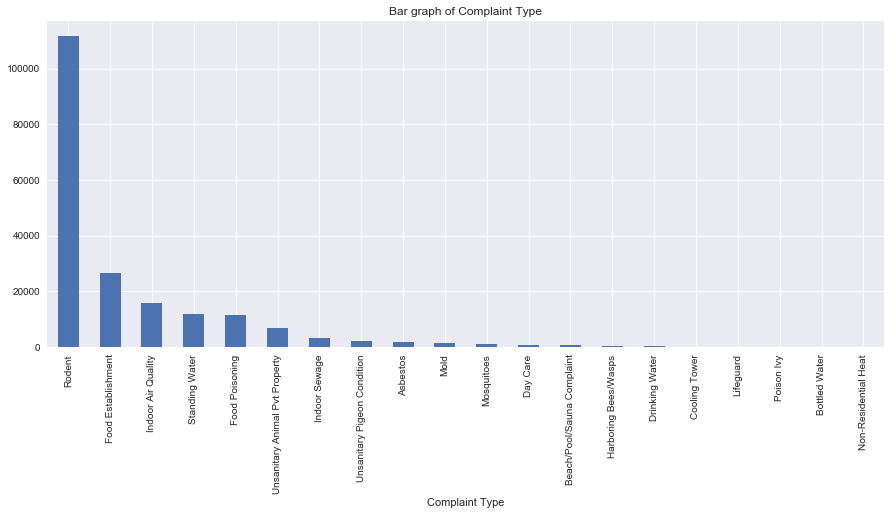

In [44]:
df_DOHMH_16_19_cleaned.groupby('Complaint Type').size().sort_values(ascending=False)[:20].plot(kind='bar', figsize=(15,6),
                                                                          title='Bar graph of Complaint Type');

Plot time series data. We can find that there is noticeable abnormality in 2019. The cases drop too much while the processing time increases a lot.

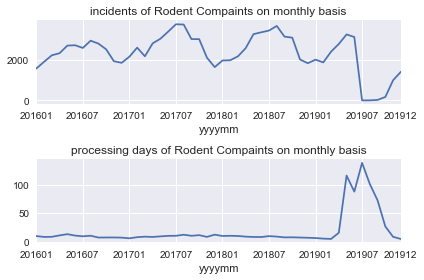

In [45]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
df_DOHMH_16_19_cleaned[df_DOHMH_16_19_cleaned['Complaint Type'] == 'Rodent'].groupby('yyyymm').size().plot(kind='line', title = 'incidents of Rodent Compaints on monthly basis', xticks = [0,6,12,18,24,30,36,42,47], ax =ax1)
df_DOHMH_16_19_cleaned[df_DOHMH_16_19_cleaned['Complaint Type'] == 'Rodent'].groupby('yyyymm').mean().float_time.plot(kind='line', title = 'processing days of Rodent Compaints on monthly basis', xticks = [0,6,12,18,24,30,36,42,47], ax=ax2)
plt.tight_layout()

In [46]:
df_DOHMH_16_19_cleaned['Resolution Summary'] = df_DOHMH_16_19_cleaned['Resolution Description'].apply(desc_replace)

In [47]:
df_DOHMH_16_19_cleaned['Resolution Summary'].value_counts(sort=True)

under review wait             158340
action taken                   27578
unknown                         6955
violations found                1291
ambiguous                       1184
no violation found               819
duplicate complaint              760
no access to the property        227
cannot complete inspection         2
Name: Resolution Summary, dtype: int64

# Investigation DOHMH 2016 - 2019 Data By Zipcode

In [48]:
# prepare the incidents count for zipcode
zip_groups = df_DOHMH_16_19_cleaned.groupby("Incident Zip")
sizes = pd.DataFrame(zip_groups.size())
sizes.rename(columns={0:"size"},inplace=True)
sizes.reset_index(level=0, inplace=True)
sizes['Zip'] = sizes['Incident Zip']
sizes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 3 columns):
Incident Zip    227 non-null object
size            227 non-null int64
Zip             227 non-null object
dtypes: int64(1), object(2)
memory usage: 5.4+ KB


In [49]:
#Center the map at Times Square
m1 = folium.Map(location = [40.7589,-73.9851],zoom_start=12)
m1.choropleth(geo_data='zipcode.geojson', data=sizes,
             columns=[ 'Zip','size'],
             key_on='feature.properties.postalCode',
             fill_color='Reds', fill_opacity=0.7, line_opacity=0.8,
             legend_name='Distribution of Incidents')
folium.LayerControl().add_to(m1)

/Users/qifuyin/anaconda3/lib/python3.6/site-packages/folium/folium.py:426: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [50]:
#add circle to highlight certain areas
folium.Circle(
    radius=5000,
    location=[40.6782, -73.9442],
    color='#3186cc',
    fill=False,
).add_to(m1)

folium.Circle(
    radius=5000,
    location=[40.7475, -73.7675],
    color='#3186cc',
    fill=False,
).add_to(m1)

Draw the heatmap for incidents counts by zipcode

In [51]:
m1

In [52]:
zip_process_time = df_DOHMH_16_19_cleaned.groupby("Incident Zip").mean().float_time
zip_mean_time = pd.DataFrame(zip_process_time)
zip_mean_time.reset_index(level=0, inplace=True)
zip_mean_time.rename(columns={'float_time':"avg_process_time"},inplace=True)
zip_mean_time['Zip'] = zip_mean_time['Incident Zip']

In [53]:
m2 = folium.Map(location = [40.7589,-73.9851],zoom_start=12)
m2.choropleth(geo_data='zipcode.geojson', data=zip_mean_time,
             columns=[ 'Zip','avg_process_time'],
             key_on='feature.properties.postalCode',
             fill_color='Reds', fill_opacity=0.7, line_opacity=0.8,
             legend_name='Distribution of Processing Time')
folium.LayerControl().add_to(m2)

In [54]:
folium.Circle(
    radius=5000,
    location=[40.6782, -73.9442],
    color='#3186cc',
    fill=False,
).add_to(m2)

folium.Circle(
    radius=5000,
    location=[40.7475, -73.7675],
    color='#3186cc',
    fill=False,
).add_to(m2)

Draw the heatmap for processing days by zipcode

In [55]:
m2

# Combined with demographics data to investigate the processing time

Read the demographics data by zipcode and merge with the 2016-2019 DOHMH 311 data

In [56]:
demographics = pd.read_csv('Demographic_Statistics_By_Zip_Code.csv')
demographics.rename(columns={'JURISDICTION NAME': 'zip_code'}, inplace=True)
demographics['zip_code'] = demographics['zip_code'].astype(str)

In [72]:
demographics.groupby('zip_code').sum()['COUNT PARTICIPANTS'].sum()/len(demographics.groupby('zip_code').sum())

17.661016949152543

In [57]:
demographics_percent = demographics[['COUNT PARTICIPANTS','zip_code','PERCENT FEMALE','PERCENT HISPANIC LATINO','PERCENT ASIAN NON HISPANIC','PERCENT WHITE NON HISPANIC','PERCENT BLACK NON HISPANIC','PERCENT PERMANENT RESIDENT ALIEN','PERCENT US CITIZEN','PERCENT RECEIVES PUBLIC ASSISTANCE']]
demographics_percent_filter = demographics_percent[demographics_percent['COUNT PARTICIPANTS'] >= 10]
zip_mean_time.rename(columns={'Zip': 'zip_code'}, inplace=True)
zip_demographics = pd.merge(demographics_percent_filter, zip_mean_time, how="inner", on=['zip_code'])

In [58]:
zip_demographics.head()

,COUNT PARTICIPANTS,zip_code,PERCENT FEMALE,PERCENT HISPANIC LATINO,PERCENT ASIAN NON HISPANIC,PERCENT WHITE NON HISPANIC,PERCENT BLACK NON HISPANIC,PERCENT PERMANENT RESIDENT ALIEN,PERCENT US CITIZEN,PERCENT RECEIVES PUBLIC ASSISTANCE,Incident Zip,avg_process_time
0,44,10001,0.50,0.36,0.07,0.02,0.48,0.05,0.95,0.45,10001,25.264716
1,35,10002,0.54,0.03,0.80,0.17,0.00,0.06,0.94,0.06,10002,23.233659
2,17,10016,0.71,0.53,0.00,0.00,0.47,0.00,1.00,0.53,10016,25.866573
3,27,10025,0.63,0.56,0.00,0.00,0.41,0.11,0.89,0.30,10025,18.580187
4,20,10029,0.65,0.20,0.00,0.00,0.75,0.00,1.00,0.40,10029,24.979148


Draw the correlation matrix to measure the relationships between ddemographics characteristics with the processing time

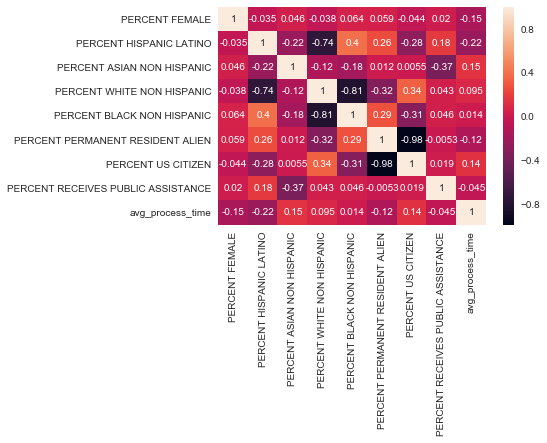

In [59]:
zip_demographics.drop(columns=['COUNT PARTICIPANTS', 'zip_code','Incident Zip'], inplace = True)
corrMatrix = zip_demographics.corr()
sns.heatmap(corrMatrix, annot=True)